<h2 style="color:#228B22; font-weight:bold; margin-bottom:0.5em;">Pretraining a GPT-Style Language Model from Scratch</h1>

<p>
<strong>Author:</strong> <span style="color:#FFD800;">Anup Sharma</span><br>
</p>

<hr style="border-top: 2px solid #888888;">

<table>
  <tr>
    <td><strong>Dataset</strong></td>
    <td>Characters: <span style="color:#228B22;">10,419</span></td>
    <td>Tokens: <span style="color:#228B22;">2,772</span></td>
  </tr>
  <tr>
    <td><strong>Model</strong></td>
    <td>Type: <span style="color:#228B22;">GPT (Transformer)</span></td>
    <td>Layers: <span style="color:#228B22;">12</span></td>
    <td>Heads: <span style="color:#228B22;">12</span></td>
    <td>Embedding Dim: <span style="color:#228B22;">768</span></td>
    <td>Context Length: <span style="color:#228B22;">256</span></td>
    <td>Epochs: <span style="color:#228B22;">10</span></td>
  </tr>
</table>

<hr style="border-top: 2px solid #888888;">

<p style="font-size:1.1em; margin-bottom:0.5em;"><strong>Workflow Overview:</strong></p>
<p>
  This notebook demonstrates how to pretrain a GPT-style language model from scratch on a small sample text dataset. The data is split into training and validation sets, and the model is trained for 10 epochs using the AdamW optimizer. At each epoch, the model processes data in batches, computes cross-entropy loss, updates its weights, periodically evaluates performance on both training and validation sets, and generates sample text to monitor progress. This workflow leverages all core features of the transformer architecture and provides a hands-on introduction to large language model pretraining.
</p>

<p style="color:#888;">
  <em>Run the cells below to inspect the dataset, model, and training process from scratch for educational purposes and future

In [4]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" #For OpenAI's pretrained weights
       ]

for p in pkgs:
    print(f"{p} version: {version(p)}")


matplotlib version: 3.10.5
numpy version: 2.2.6
tiktoken version: 0.11.0
torch version: 2.8.0
tensorflow version: 2.20.0


In [11]:
#working directory
import os
print(os.getcwd())

/Users/anup/gitProjects/language-models-psychiatry


In [ ]:
import torch
from gpt_from_scratch import GPTModel


<class 'gpt_from_scratch.GPTModel'>


In [16]:
#Inspect the GPT Model
import inspect
from gpt_from_scratch import GPTModel

from IPython.display import display, Markdown
display(Markdown(f"```python\n{inspect.getsource(GPTModel)}\n```"))

```python
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

```

In [18]:
#config file that contains model parameters for GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [20]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  #Disable dropout during inference

In [ ]:
#View of the model architecture
from IPython.display import display
display(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [30]:
#View of the model's parameters
for name, param in model.named_parameters():
    print(name, param.shape)

print(f"\nnumber of parameter layers: {len(list(model.named_parameters()))}")

tok_emb.weight torch.Size([50257, 768])
pos_emb.weight torch.Size([256, 768])
trf_blocks.0.att.W_query.weight torch.Size([768, 768])
trf_blocks.0.att.W_key.weight torch.Size([768, 768])
trf_blocks.0.att.W_value.weight torch.Size([768, 768])
trf_blocks.0.att.out_proj.weight torch.Size([768, 768])
trf_blocks.0.att.out_proj.bias torch.Size([768])
trf_blocks.0.ff.layers.0.weight torch.Size([3072, 768])
trf_blocks.0.ff.layers.0.bias torch.Size([3072])
trf_blocks.0.ff.layers.2.weight torch.Size([768, 3072])
trf_blocks.0.ff.layers.2.bias torch.Size([768])
trf_blocks.0.norm1.scale torch.Size([768])
trf_blocks.0.norm1.shift torch.Size([768])
trf_blocks.0.norm2.scale torch.Size([768])
trf_blocks.0.norm2.shift torch.Size([768])
trf_blocks.1.att.W_query.weight torch.Size([768, 768])
trf_blocks.1.att.W_key.weight torch.Size([768, 768])
trf_blocks.1.att.W_value.weight torch.Size([768, 768])
trf_blocks.1.att.out_proj.weight torch.Size([768, 768])
trf_blocks.1.att.out_proj.bias torch.Size([768])
trf_b

In [52]:
#This block of code follows after viewing the GPT-2 model architecture and weights to transition from model inspection to practical usage. It ensures the tokenizer is available, adds the current directory to the Python path so local modules can be imported, and then imports the generate_text_simple function, which is essential for generating new text with the model.

import tiktoken

# Add the current notebook's directory to sys.path
import sys
import os
sys.path.append(os.getcwd())

#Import generate_text_simple function from gpt_from_scratch.py
from gpt_from_scratch import generate_text_simple

#Visualize the function
import inspect
from IPython.display import display, Markdown
display(Markdown(f"```python\n{inspect.getsource(generate_text_simple)}\n```"))


```python
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

```

In [63]:
#This block demonstrates how to use the loaded GPT-2 model for text generation. It defines helper functions to convert text to token IDs and back (i.e. encode and decode) and then uses the generate_text_simple function to generate next tokens from the model. Finally, it decodes and prints the generated output as readable text, showing the practical application of th emodel for generating language.

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:",token_ids_to_text(token_ids, tokenizer))


Output text: Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [ ]:
#Defines two small batch of tokenized inputs and their corresponding target sequences. The targets are the next tokens for each input, which is is standard in language modeling.

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [ ]:
#Decodes a sequence of token IDS from a previous generation step into human readable text using the tokenizer.

decoded_text = tokenizer.decode(token_ids.squeeze(0).tolist())
print(decoded_text)

Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [ ]:
#Passes the inputs batch through the GPT model to get raw output scores (logits) for each token position and vocabulary entry. Applies softmax to convert logist to probabilities over the vocabulary for each token position.

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [ ]:
#For each token position, selects the token ID with the highest probability. token_ids now contains the model's predicted next token for each position in the batch.

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [ ]:
#Decodes the first row of targets and model's predicted token_ids back to text for easy comparison. Allows one to see how well the model's predictions (in this untrained model) match the expected next tokens.

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [71]:
#Extracts probabilities assigned by the model to the correct or next tokens for each position in both input sequences

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [ ]:
#Computes the log-probabilities of the correct tokens and then averages them. The average log-probability is a standard metric for model performance (higher is better) and is the basis for cross entropy calculations.

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)


In [74]:
#Negates the average log-probability to convert it into a loss (since optimization frameworks minimize loss. This is the cross-entropy value, the standard function for language modeling.

neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [ ]:
#Checking the shape of the inputs and outputs.
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [77]:
#Flatten tensors by combining them over the batch dimension.
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [78]:
#Using PyTorch built-in cross-entropy function to compute the loss in a numerically stable and efficient way.

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [ ]:
#Calculates perplexity, a commonly used metric in language modeling that is the exponentiated cross-entrophy loss. (i.e. lower perplexity means the model is more confident and accurate in its predictions)

perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


In [ ]:
#Download and load a small text dataset for training and validation

import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [97]:
#Checking the text
print(text_data[:99])
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [ ]:
#Text length in terms of characters and tokens

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 20479
Tokens: 5145


In [98]:
#Divide the dataset into a training and validation set and use the data loaders to prepare the batches for language model training

from gpt_from_scratch import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check for errors

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [104]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("Validation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [120]:
#Confirming token sizes are in the expected range.

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print(f"All tokens are: {train_tokens} + {val_tokens} or",  train_tokens + val_tokens)



Training tokens: 4608
Validation tokens: 512
All tokens are: 4608 + 512 or 5120


In [112]:
#Define utility functions to compute loss for a batch or an entire DataLoader

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [143]:
#Moves the model to the appropriate device (CPU/GPU/MPS), computes and prints the intitial training and validation losses. This establishes a baseline before training.


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

model.to(device)

torch.manual_seed(123)
with torch.no_grad(): #Disable gradient tracking not yet training
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using mps device.
Training loss: 0.10826531797647476
Validation loss: 6.802339553833008


In [144]:
def training_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients from prior batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculates the gradients
            optimizer.step()  # Update model weights
            tokens_seen += input_batch.numel()
            global_step += 1

        # Optional evaluation step
        if global_step % eval_freq == 0:
            train_loss, val_loss = evaluate_model(
                model, train_loader, val_loader, device, eval_iter)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            track_tokens_seen.append(tokens_seen)
            print(f"Ep {epoch+1} (Step {global_step:06d}): "
                  f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [145]:
#Now train model with the execution time

import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = training_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=4, eval_iter=4,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time)/ 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000008): Train loss 7.310, Val loss 7.465
Every effort moves you,,,,,,,,,,,,.                                     
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Every effort moves you.                                                 
Every effort moves you.                           " I had a I had" I had the picture had to the picture and I had to me--I
Ep 5 (Step 000044): Train loss 3.551, Val loss 6.204
Every effort moves you know to                                                
Every effort moves you know it to see a little to have to the picture--I looked of that he had been--I had to see it was to see the donkey, and in the picture at my elbow and in the donkey, and down the room, with the
Every effort moves you know it was not that the picture for a smile that, I was not--so it was no--the the fact, with a little a smile behind his pictures--I had been his own he ha

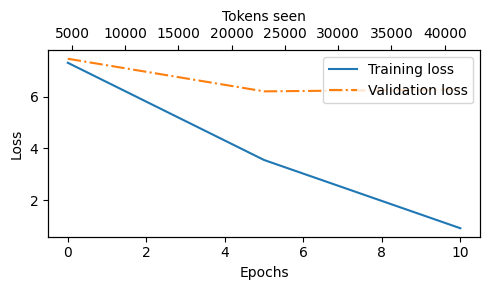

In [146]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [151]:
#This cell moves the trained model to the CPU and sets it to evaluation mode (disabling dropout and other training-specific behaviors). It initializes the GPT-2 tokenizer, then generates 25 new tokens of text starting from the prompt "Every effort moves you" using the generate_text_simple function. The generated token IDs are decoded back to text and printed. This demonstrates how to use the trained model for inference (text generation) after training is complete.

model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [152]:
#This code block demonstrates how to generate the next token using a sample vocabulary and a set of logits. It applies softmax to convert logits to probabilities, then uses argmax to select the most likely token, and prints the corresponding word. This illustrates the standard greedy decoding approach.

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [153]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [154]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


In [155]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

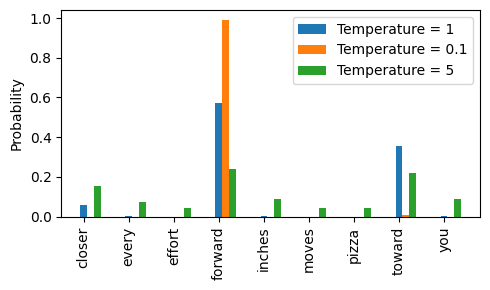

In [156]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [157]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


In [ ]:
#Top-K sampling

top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [159]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [160]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [ ]:
#Modifiying the text generation function using temperature scaling and top-k sampling.

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [162]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"" Gisburn rather a--I felt nervous and uncertain.



In [165]:
#Loading and saving the model weights in PyTorch

torch.save(model.state_dict(), "model.pth")

In [167]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

In [169]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [170]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

### Loading pretrained weights from OpenAI GPT-2 (a fully pretrained AI model)


In [181]:
#Loading pretrained weights from OpenAI
#pip install tensorflow tqdm
import os

In [182]:

print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.20.0
tqdm version: 4.67.1


In [187]:
#Import the download_and_load_gpt2 function
from gpt_from_scratch import download_and_load_gpt2



ImportError: cannot import name 'download_and_load_gpt2' from 'gpt_from_scratch' (/Users/anup/gitProjects/language-models-psychiatry/gpt_from_scratch.py)